In [47]:
import librosa
import librosa.display
import librosa.feature
import soundfile
import os, glob, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from pycaret.classification import setup, compare_models, plot_model
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D,
    Conv1D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout,
    Concatenate,
    Reshape,
    MaxPooling1D,
    GlobalAveragePooling1D,
    GlobalAveragePooling2D,
)
from tensorflow.keras.regularizers import l2  
from tensorflow.keras.optimizers import Adam






# Data Collection

### Voice messages database creation

In [48]:
wav_files = 'voice_file/'


In [49]:
# ravdess data
ravdess_directory_list = os.listdir(wav_files)

file_emotion = []
file_path = []
temp = []

for dir in ravdess_directory_list:
    actor_files = os.listdir(os.path.join(wav_files, dir))
    for file in actor_files:
        part = file.split('.')[0]
        part = part.split('-')
        temp.append(part)
        file_path.append(wav_files + dir + '/' + file)
    for i in temp:
        if len(i) >= 3:  
            file_emotion.append(int(i[2]))  
        else:
            file_emotion.append(None)
            


path_df = pd.DataFrame(file_path, columns=['path'])
emotion_df = pd.DataFrame(file_emotion, columns=['emotions'])
emotion_df.dropna(inplace=True)

ravdess_df = pd.concat([emotion_df, path_df], axis=1)


ravdess_df.emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df['emotion_num'] = file_emotion


ravdess_df.dropna(inplace=True)
ravdess_df['emotions'].value_counts()

calm        192
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
neutral      96
Name: emotions, dtype: int64

In [50]:
ravdess_df

,emotions,path,emotion_num
0,neutral,voice_file/Actor_01/03-01-01-01-01-01-01.wav,1
1,neutral,voice_file/Actor_01/03-01-01-01-01-02-01.wav,1
2,neutral,voice_file/Actor_01/03-01-01-01-02-01-01.wav,1
3,neutral,voice_file/Actor_01/03-01-01-01-02-02-01.wav,1
4,calm,voice_file/Actor_01/03-01-02-01-01-01-01.wav,2
...,...,...,...
1435,surprise,voice_file/Actor_24/03-01-08-01-02-02-24.wav,8
1436,surprise,voice_file/Actor_24/03-01-08-02-01-01-24.wav,8
1437,surprise,voice_file/Actor_24/03-01-08-02-01-02-24.wav,8
1438,surprise,voice_file/Actor_24/03-01-08-02-02-01-24.wav,8


In [51]:
# crema data
crema_directory_list = os.listdir('Crema')

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append('Crema/' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)

crema_df['emotion_num'] = file_emotion
crema_df['emotion_num'].replace({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5 , 'fear':6, 'disgust':7, 'surprise':8}, inplace=True)

# print(Crema_df.emotions.value_counts())
crema_df['emotions'].value_counts()

disgust    1270
fear       1270
happy      1270
sad        1270
angry      1269
neutral    1086
Name: emotions, dtype: int64

In [52]:
dir_list = os.listdir('Savee')

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
    elif i[-8:-6]=='sa':
        emotion.append('sad')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
    else:
        emotion.append('unknown') 
    path.append('Savee/' + i)

# Now check out the label count distribution 
savee_df = pd.DataFrame(emotion, columns = ['emotions'])
savee_df = pd.concat([savee_df, pd.DataFrame(path, columns = ['path'])], axis = 1)

savee_df['emotion_num'] = emotion
savee_df['emotion_num'].replace({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5 , 'fear':6, 'disgust':7, 'surprise':8}, inplace=True)

savee_df['emotions'].value_counts()

neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: emotions, dtype: int64

In [53]:
Tess = 'Tess/'
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotions'])



# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])

tess_df = pd.concat([emotion_df, path_df], axis=1)
tess_df['emotion_num'] = file_emotion
tess_df['emotion_num'].replace({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5 , 'fear':6, 'disgust':7, 'surprise':8}, inplace=True)
tess_df.head()

,emotions,path,emotion_num
0,angry,Tess/OAF_angry/OAF_back_angry.wav,5
1,angry,Tess/OAF_angry/OAF_bar_angry.wav,5
2,angry,Tess/OAF_angry/OAF_base_angry.wav,5
3,angry,Tess/OAF_angry/OAF_bath_angry.wav,5
4,angry,Tess/OAF_angry/OAF_bean_angry.wav,5


In [54]:
# Concat 

df = pd.concat([ravdess_df, crema_df, savee_df, tess_df], axis=0)

In [55]:
df.reset_index(drop=True, inplace=True)

In [56]:
df

,emotions,path,emotion_num
0,neutral,voice_file/Actor_01/03-01-01-01-01-01-01.wav,1
1,neutral,voice_file/Actor_01/03-01-01-01-01-02-01.wav,1
2,neutral,voice_file/Actor_01/03-01-01-01-02-01-01.wav,1
3,neutral,voice_file/Actor_01/03-01-01-01-02-02-01.wav,1
4,calm,voice_file/Actor_01/03-01-02-01-01-01-01.wav,2
...,...,...,...
12150,sad,Tess/YAF_sad/YAF_witch_sad.wav,4
12151,sad,Tess/YAF_sad/YAF_yearn_sad.wav,4
12152,sad,Tess/YAF_sad/YAF_yes_sad.wav,4
12153,sad,Tess/YAF_sad/YAF_young_sad.wav,4


# Signal Exploration & Extraction 


#### Triming quiet parts out 

In [57]:
file_path = 'voice_file/Actor_09/03-01-02-01-01-01-09.wav'

y, sr = librosa.load(str(file_path))
y_trim, _ = librosa.effects.trim(y, top_db=30)



In [58]:
stft=np.abs(librosa.stft(y))

np.mean(stft)

0.0061838925

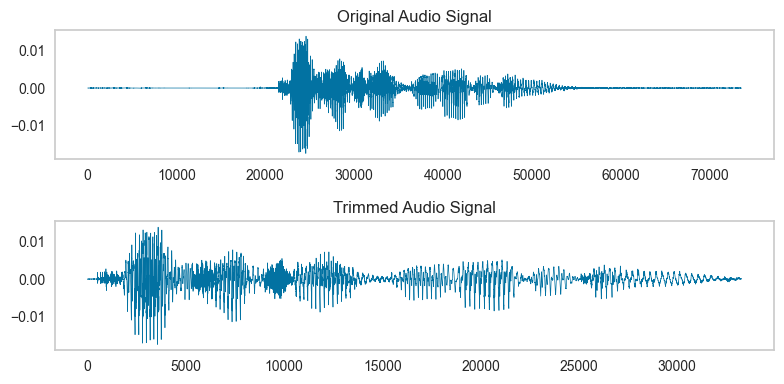

In [59]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4))

axes[0].plot(y, lw=0.5)
axes[0].set_title('Original Audio Signal')
axes[0].grid(False)

axes[1].plot(y_trim, lw=0.5)
axes[1].set_title('Trimmed Audio Signal')
axes[1].grid(False)

plt.tight_layout()
plt.show()

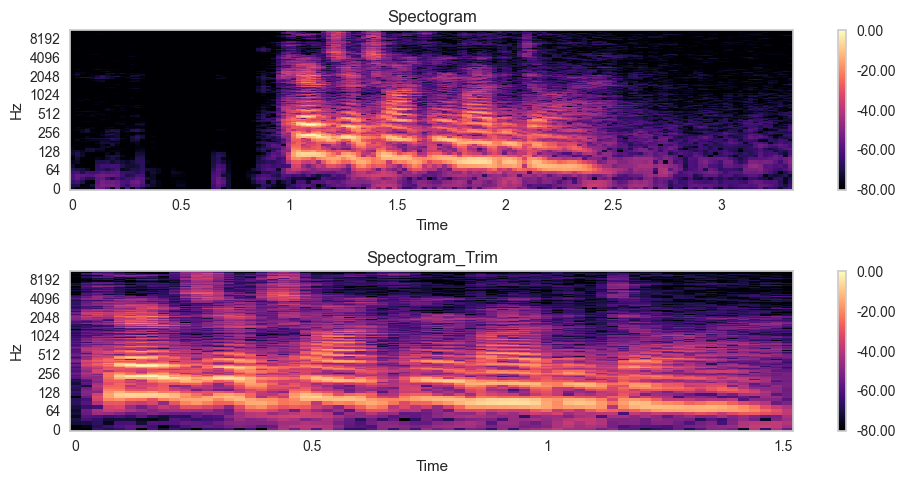

In [60]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

D_trim = librosa.stft(y_trim)
S_db_t = librosa.amplitude_to_db(np.abs(D_trim), ref=np.max)

fig, ax = plt.subplots(2, 1, figsize=(10,5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax[0])
fig.colorbar(img, ax=ax[0], format=f'%0.2f')
ax[0].set_title('Spectogram')


img2 = librosa.display.specshow(S_db_t,
                              x_axis='time',
                              y_axis='log',
                              ax=ax[1])
ax[1].set_title('Spectogram_Trim')
fig.colorbar(img, ax=ax[1], format=f'%0.2f')
plt.tight_layout()
plt.show()

In [61]:
D_trim.shape

(1025, 66)

In [62]:
y, sr = librosa.load(str(df['path'][0]))
Mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=y , sr=sr))
mel_mean = np.mean(Mel_spectrogram)
mel_mean = mel_mean.tolist()

type(Mel_spectrogram)

numpy.float32

In [63]:
# Consider tf.image.resize_with_pad

from tensorflow.image import resize
target_shape=(32,32)
y, sr = librosa.load(str(df['path'][0]))
# y_stretched = le.time_stretch(y, rate=1)
Mel_spectrogram = librosa.feature.melspectrogram(y=y , sr=sr)
Mel_spectrogram = resize(np.expand_dims(Mel_spectrogram,axis=-1),target_shape)

In [64]:
(Mel_spectrogram)

<tf.Tensor: shape=(32, 32, 1), dtype=float32, numpy=
array([[[2.7327665e-10],
        [8.4925951e-09],
        [3.2372900e-09],
        ...,
        [8.2438405e-08],
        [2.8987899e-09],
        [7.5012334e-09]],

       [[2.2112058e-10],
        [2.6401685e-09],
        [1.8061204e-09],
        ...,
        [1.4090556e-08],
        [8.2717044e-10],
        [2.9909324e-09]],

       [[1.5353202e-10],
        [7.9605461e-10],
        [1.1195413e-09],
        ...,
        [5.6640048e-09],
        [5.6897997e-10],
        [7.4288303e-10]],

       ...,

       [[7.3303467e-11],
        [1.7491346e-10],
        [3.6086895e-10],
        ...,
        [1.3479977e-09],
        [1.6796090e-10],
        [1.1495126e-09]],

       [[3.8150386e-11],
        [4.1761691e-10],
        [3.1842812e-10],
        ...,
        [1.3264299e-09],
        [2.9648611e-10],
        [4.3359524e-10]],

       [[4.1370411e-11],
        [2.0061056e-10],
        [9.4716929e-11],
        ...,
        [1.0076695e-0

In [119]:
# Extracting Features 

def extract_features(file_path):
    target_shape=(32,32)
    # Load the audio file
    y, sr = librosa.load(str(file_path))
    y, _ = librosa.effects.trim(y, top_db=30)
    
    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    rms_energy = librosa.feature.rms(y=y)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    stft = np.abs(librosa.stft(y))
    Mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=y , sr=sr))
#     # -------------------------------------------------------------------------
    # mel_spec = librosa.feature.melspectrogram(y=y , sr=sr)
    # mel_spec = resize(np.expand_dims(Mel_spectrogram,axis=-1),target_shape)


    # Calculate mean and standard deviation for each feature
    mfccs_mean = mfccs.mean(axis=1)
    mfccs_std = mfccs.std(axis=1)
    spectral_centroid_mean = spectral_centroid.mean(axis=1)
    spectral_bandwidth_mean = spectral_bandwidth.mean(axis=1)
    spectral_contrast_mean = spectral_contrast.mean(axis=1)
    zero_crossing_rate_mean = zero_crossing_rate.mean()
    rms_energy_mean = rms_energy.mean()
    stft_mean = np.mean(stft)
    mel_mean = np.mean(Mel_spectrogram)
    

    



    # Convert NumPy arrays to lists
    mfccs_mean = mfccs_mean.tolist()
    mfccs_std = mfccs_std.tolist()
    spectral_centroid_mean = spectral_centroid_mean.tolist()
    spectral_bandwidth_mean = spectral_bandwidth_mean.tolist()
    spectral_contrast_mean = spectral_contrast_mean.tolist()
    # chroma_mean = chroma_mean.tolist()
    stft_mean = stft_mean.tolist()
    mel_mean = mel_mean.tolist()
    
    

    # Create a dictionary with features
    features = {
        'mfccs_mean': mfccs_mean,
        'mfccs_std': mfccs_std,
        'spectral_centroid_mean': spectral_centroid_mean,
        'spectral_bandwidth_mean': spectral_bandwidth_mean,
        'spectral_contrast_mean': spectral_contrast_mean,
        'zero_crossing_rate_mean': zero_crossing_rate_mean,
        'rms_energy_mean': rms_energy_mean,
        # 'chroma_mean': chroma_mean,
        'stft_mean': stft_mean,
        'mel_mean': mel_mean
        # 'mel_spec': mel_spec
    }
    
    # Create lists to store values of each feature
    features_lists = []
    column_names = []
    for key, value in features.items():
        if isinstance(value, list):
            for i, v in enumerate(value):
                features_lists.append(v)
                column_names.append(f"{key}_{i+1}")
        else:
            features_lists.append(value)
            column_names.append(key)
    
    # Create DataFrame
    df_features = pd.DataFrame([features_lists], columns=column_names)
    
    return df_features

# Example usage:
# file_path = df['path'][0] 
# features = extract_features(file_path)
# features


In [66]:
feature_dfs = []
for file_path in df['path']:
    features = extract_features(file_path)
    feature_dfs.append(features)

all_features = pd.concat(feature_dfs, ignore_index=True)

In [67]:
all_features

,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,...,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_mean_7,zero_crossing_rate_mean,rms_energy_mean,stft_mean,mel_mean
0,-485.435760,125.547394,-9.674954,24.648430,14.435009,-5.135542,-9.597648,-12.427287,-28.499622,-9.909325,...,14.145593,19.656225,17.042092,17.556508,21.315934,46.029319,0.085197,0.005515,0.040950,0.008891
1,-482.768616,116.302711,-7.825343,29.099020,13.977192,-7.079821,-8.166739,-14.216775,-28.183737,-6.398925,...,14.964992,20.244835,18.056549,17.641812,21.521437,44.983191,0.079027,0.005851,0.041498,0.010211
2,-473.852509,124.038818,-6.438735,27.357557,6.484826,-2.441445,-8.439914,-14.846803,-25.888828,-10.471822,...,16.004752,19.855597,17.040053,17.605381,21.148922,44.518761,0.094003,0.006804,0.051687,0.014078
3,-471.156189,114.611877,-0.160490,28.123051,9.483885,0.481433,-8.060109,-17.652515,-24.048738,-8.849402,...,14.183022,19.671542,18.481318,17.496498,19.287410,43.730301,0.098757,0.006484,0.051746,0.013249
4,-537.455322,115.149658,-0.266134,27.281794,11.806399,-0.392789,-10.151818,-9.871162,-21.435678,-11.071152,...,14.233578,19.776349,17.337756,18.493992,19.873452,44.796344,0.103906,0.003594,0.025402,0.004338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12150,-390.519806,61.717083,34.842991,42.624744,-2.211940,8.651980,-1.193717,-11.482418,0.572330,-4.430357,...,20.086075,21.581853,17.924931,18.715964,19.557527,46.862418,0.167666,0.031352,0.183248,0.335295
12151,-404.340485,76.251541,25.959826,39.575932,0.379420,-0.940992,-6.228340,-14.371888,1.734153,-11.790402,...,22.511488,23.683262,19.526807,18.990943,20.260181,47.407920,0.119279,0.037568,0.174598,0.417742
12152,-369.292999,65.638329,38.604298,41.265652,-4.771121,4.277835,-0.704074,-9.792727,2.102644,-7.646012,...,20.117561,22.368360,19.256551,19.125917,20.721160,47.295697,0.172898,0.043251,0.208830,0.638534
12153,-411.443359,71.021622,30.941570,38.807365,-3.760754,12.765188,-3.693024,-13.331684,-1.731160,-5.464870,...,23.282892,24.112504,18.238850,19.655744,19.514454,46.163786,0.112699,0.030887,0.151849,0.303263


In [68]:
# url = 'all_features_df.csv'

# all_features = pd.read_csv(url)
# all_features = all_features.drop(['Unnamed: 0'], axis=1)

In [70]:
# all_features.emotions.value_counts()

In [71]:
# all_features.hist(grid=False, figsize=(15,15))
# plt.tight_layout()
# plt.show()

In [72]:
df.reset_index(inplace=True, drop=True)
combined_df.reset_index(inplace=True, drop=True)


In [73]:
combined_df = pd.concat([all_features, df['emotion_num']], axis=1)

In [74]:
combined_df.to_csv('combined_df.csv')

In [75]:
combined_df['emotion_num'].isna().sum()

0

In [76]:
combined_df['emotion_num'].value_counts()

3    1922
4    1922
6    1922
7    1922
5    1921
1    1702
8     652
2     192
Name: emotion_num, dtype: int64

In [77]:
from scipy.stats import pointbiserialr



correlation_results = {}

for column in combined_df.columns:
    if column != 'emotion_num':
        corr, _ = pointbiserialr(combined_df[column], df['emotion_num'])
        correlation_results[column] = corr


sorted_results = sorted(correlation_results.items(), key=lambda x: abs(x[1]), reverse=True)

# Display the sorted correlation results
for feature, corr in sorted_results:
    print(f"{feature}: {corr}")

    
    


zero_crossing_rate_mean: 0.18798797942749085
spectral_centroid_mean_1: 0.18347184217370271
mfccs_mean_4: -0.1739255384498864
mfccs_std_13: 0.1633238555396436
mfccs_std_5: 0.1571998977166922
mfccs_mean_1: 0.15546519768258404
mfccs_mean_2: -0.14445392332728624
mfccs_mean_3: -0.13973637628120972
mfccs_std_11: 0.13837526606766357
mfccs_std_12: 0.13085930013291386
mfccs_mean_5: -0.12901351917539713
mfccs_std_6: 0.12430938890014863
mfccs_std_10: 0.11810448394855148
spectral_bandwidth_mean_1: 0.11414281484013336
mfccs_std_4: 0.11298890789477667
mfccs_std_1: 0.11191579156186812
mfccs_std_3: 0.1068169471318571
stft_mean: 0.10678700548041829
mfccs_std_8: 0.10674266936552451
mfccs_std_9: 0.10343278501694662
mfccs_mean_9: -0.10162515390789405
mfccs_std_2: 0.10000211864801346
mfccs_mean_11: -0.09728271311816138
mfccs_mean_6: -0.09008070731093372
rms_energy_mean: 0.08733709465665361
mfccs_mean_7: -0.07959552997463878
mfccs_std_7: 0.07371809522956259
mel_mean: 0.06829936233838244
spectral_contrast_me

In [78]:
# # Using Pycaret testing sevral models
# setup(combined_df, target='emotion_num')

# # Compare models
# best_model = compare_models(cross_validation=True)

In [79]:
# Scalers

pt = PowerTransformer()
minScaler = MinMaxScaler()
stdScaler = StandardScaler()

In [80]:


X = combined_df.drop(columns=['emotion_num'])  
y = combined_df[['emotion_num']]  

print(y.shape, X.shape)

(12155, 1) (12155, 39)


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
# Normaliztiion 

pt.fit(X_train)
minScaler.fit(X_train)
stdScaler.fit(X_train)

X_train_scaled = minScaler.transform(X_train)
X_test_scaled = minScaler.transform(X_test)

# X_train_scaled = stdScaler.transform(X_train)
# X_test_scaled = stdScaler.transform(X_test)

# X_train_scaled = pt.transform(X_train)
# X_test_scaled = pt.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)



In [83]:
clf = ExtraTreesClassifier(bootstrap=False, max_depth=None, max_features='sqrt')    

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6285479226655697
Classification Report:
              precision    recall  f1-score   support

           1       0.52      0.67      0.58       328
           2       0.56      0.79      0.65        38
           3       0.55      0.60      0.57       379
           4       0.62      0.72      0.67       395
           5       0.72      0.79      0.75       385
           6       0.71      0.40      0.51       389
           7       0.62      0.50      0.55       377
           8       0.89      0.83      0.86       140

    accuracy                           0.63      2431
   macro avg       0.65      0.66      0.64      2431
weighted avg       0.64      0.63      0.62      2431



In [84]:
cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=7)
#gridsearch_cv 

for i, score in enumerate(cv_scores):
    print(f'fold {i+1}: {score}')

mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

fold 1: 0.6230215827338129
fold 2: 0.6313894888408927
fold 3: 0.6299496040316774
fold 4: 0.6133909287257019
fold 5: 0.6061915046796257
fold 6: 0.6241900647948164
fold 7: 0.6400287976961843
Mean Accuracy: 0.6240231387861017


In [85]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# grid_search = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
# grid_search.fit(X_train_scaled, y_train)


# print("Best Parameters:", grid_search.best_params_)
# best_clf = grid_search.best_estimator_
# y_pred = best_clf.predict(X_test_scaled)


# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# print("Classification Report:")
# print(classification_report(y_test, y_pred))

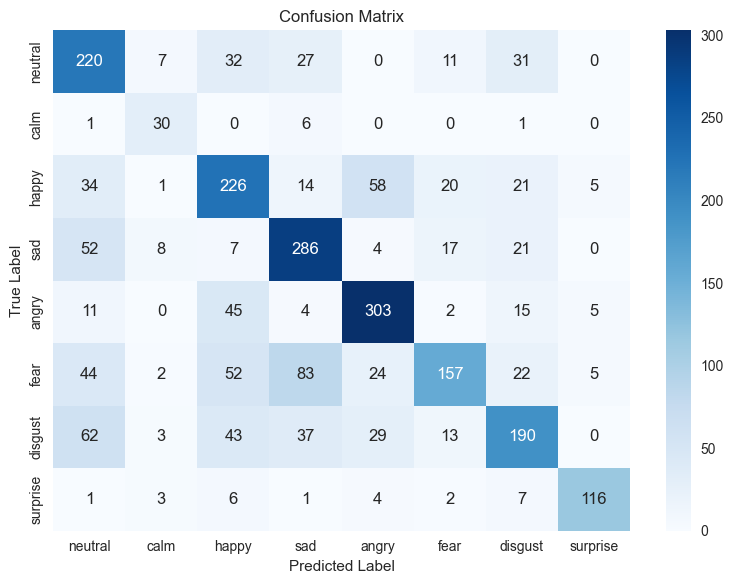

In [86]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

clases = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clases, yticklabels=clases)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [87]:
#As always we need to expand the dimensions, so we can input the data to NN.
X_train_cnn = np.expand_dims(X_train, axis=2) 
X_test_cnn = np.expand_dims(X_test, axis=2)

In [88]:
print(X_train_cnn.shape, y_train.shape, X_test_cnn.shape, y_test.shape)

(9724, 39, 1) (9724, 1) (2431, 39, 1) (2431, 1)


In [89]:
y_test['emotion_num'] = y_test['emotion_num'].apply(lambda x: x-1)

In [90]:
y_train['emotion_num'] = y_train['emotion_num'].apply(lambda x: x-1)

In [91]:
print(y_train.value_counts(),'\n', y_test.value_counts())

emotion_num
6              1545
2              1543
4              1536
5              1533
3              1527
0              1374
7               512
1               154
dtype: int64 
 emotion_num
3              395
5              389
4              385
2              379
6              377
0              328
7              140
1               38
dtype: int64


In [105]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the input shape based on your data
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])

# Initialize the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Flatten the output
model.add(Flatten())

# Add a dense (fully connected) layer
model.add(Dense(64, activation='relu'))

# Add the output layer with appropriate activation function
# Assuming you have a multi-class classification problem
num_classes = len(np.unique(y_train))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 37, 64)            256       
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 18, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_23 (Conv1D)          (None, 16, 64)            12352     
                                                                 
 max_pooling1d_23 (MaxPooli  (None, 8, 64)             0         
 ng1D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 64)              

In [93]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the input shape based on your data
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])

# Initialize the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add a dropout layer
model.add(Dropout(0.2))  # Adjust the dropout rate as needed

# Flatten the output
model.add(Flatten())

# Add a dense (fully connected) layer
model.add(Dense(64, activation='relu'))

# Add the output layer with appropriate activation function
# Assuming you have a multi-class classification problem
num_classes = len(np.unique(y_train))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 37, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 18, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 16, 64)            12352     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 8, 64)             0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 8, 64)             0         
                                                                 
 flatten_1 (Flatten)         (None, 512)              

In [106]:
history = model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2)

# 3. Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
244/244 [==============================] - 5s 15ms/step - loss: 5.4880 - accuracy: 0.2473 - val_loss: 2.2313 - val_accuracy: 0.2051
Epoch 2/50
244/244 [==============================] - 4s 15ms/step - loss: 2.2619 - accuracy: 0.2814 - val_loss: 2.6583 - val_accuracy: 0.2817
Epoch 3/50
244/244 [==============================] - 4s 15ms/step - loss: 1.9513 - accuracy: 0.3318 - val_loss: 1.9102 - val_accuracy: 0.3239
Epoch 4/50
244/244 [==============================] - 3s 14ms/step - loss: 1.7705 - accuracy: 0.3547 - val_loss: 2.8133 - val_accuracy: 0.1933
Epoch 5/50
244/244 [==============================] - 3s 13ms/step - loss: 1.6609 - accuracy: 0.3841 - val_loss: 1.7692 - val_accuracy: 0.3563
Epoch 6/50
244/244 [==============================] - 3s 14ms/step - loss: 1.6152 - accuracy: 0.4024 - val_loss: 1.7522 - val_accuracy: 0.3702
Epoch 7/50
244/244 [==============================] - 4s 15ms/step - loss: 1.4597 - accuracy: 0.4452 - val_loss: 1.8015 - val_accuracy: 0.3650

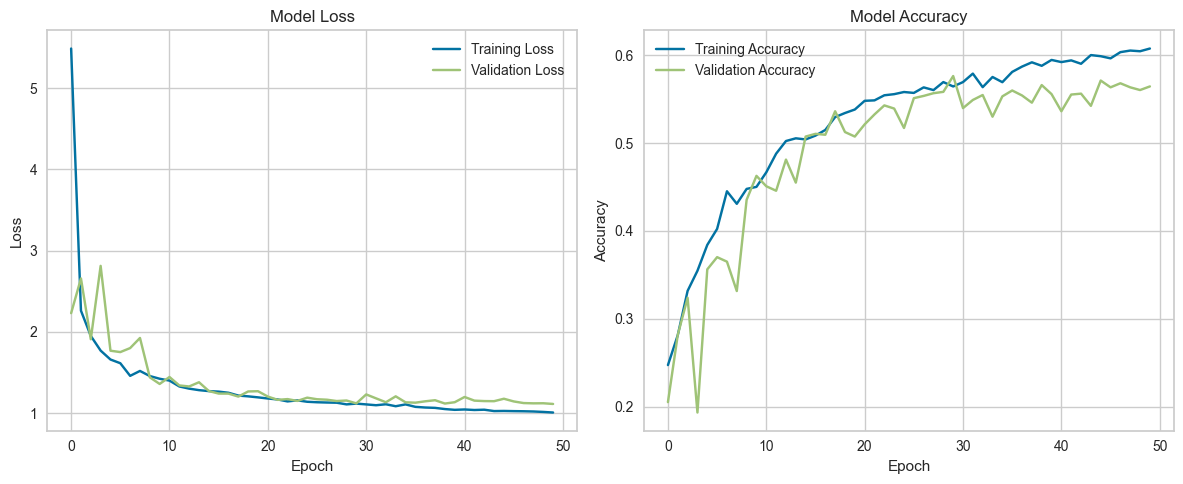

In [107]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Training model 1/4 with hyperparameters: {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.2}
Training model 2/4 with hyperparameters: {'filters': 64, 'kernel_size': 3, 'dropout_rate': 0.3}
Training model 3/4 with hyperparameters: {'filters': 64, 'kernel_size': 5, 'dropout_rate': 0.2}
Training model 4/4 with hyperparameters: {'filters': 128, 'kernel_size': 3, 'dropout_rate': 0.3}


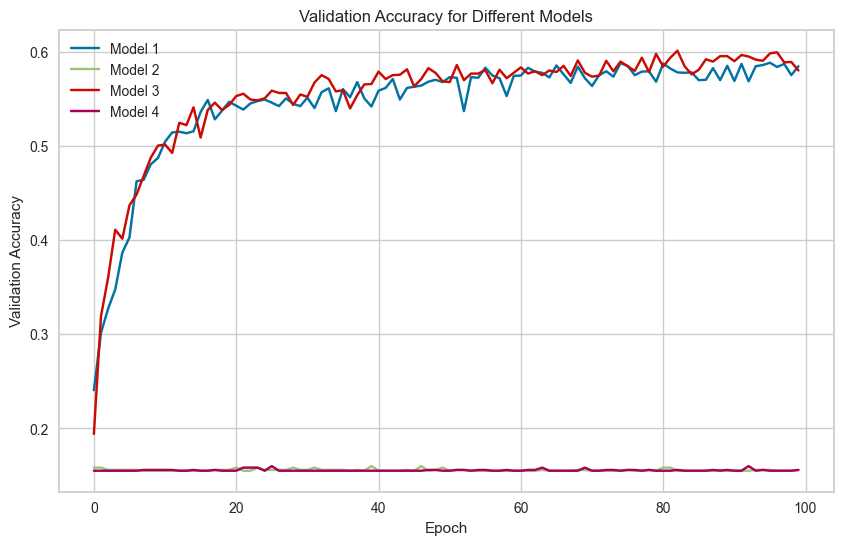

In [96]:
import matplotlib.pyplot as plt

# Define different sets of hyperparameters
hyperparameters = [
    {'filters': 32, 'kernel_size': 3, 'dropout_rate': 0.2},
    {'filters': 64, 'kernel_size': 3, 'dropout_rate': 0.3},
    {'filters': 64, 'kernel_size': 5, 'dropout_rate': 0.2},
    {'filters': 128, 'kernel_size': 3, 'dropout_rate': 0.3}
]

# Initialize lists to store validation accuracy for each run
val_accuracy_history = []

# Iterate over different sets of hyperparameters
for i, params in enumerate(hyperparameters):
    print(f"Training model {i + 1}/{len(hyperparameters)} with hyperparameters: {params}")

    # Initialize the model
    model = Sequential()

    # Add convolutional layers
    model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(params['dropout_rate']))

    # Flatten the output
    model.add(Flatten())

    # Add dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_cnn, y_train, epochs=100, validation_data=(X_test_cnn, y_test), verbose=0)

    # Append validation accuracy history to the list
    val_accuracy_history.append(history.history['val_accuracy'])

# Plot validation accuracy for each run
plt.figure(figsize=(10, 6))
for i, val_acc in enumerate(val_accuracy_history):
    plt.plot(val_acc, label=f"Model {i+1}")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Models')
plt.legend()
plt.grid(True)
plt.show()


Training model 1/4 with hyperparameters: {'learning_rate': 0.001, 'dropout_rate': 0.2}
Train accuracy: 0.6320444345474243, Validation accuracy: 0.5902920365333557
Training model 2/4 with hyperparameters: {'learning_rate': 0.01, 'dropout_rate': 0.3}
Train accuracy: 0.15096667408943176, Validation accuracy: 0.15508021414279938
Training model 3/4 with hyperparameters: {'learning_rate': 0.0001, 'dropout_rate': 0.2}
Train accuracy: 0.6070547103881836, Validation accuracy: 0.5874125957489014
Training model 4/4 with hyperparameters: {'learning_rate': 0.005, 'dropout_rate': 0.3}
Train accuracy: 0.15950226783752441, Validation accuracy: 0.15508021414279938


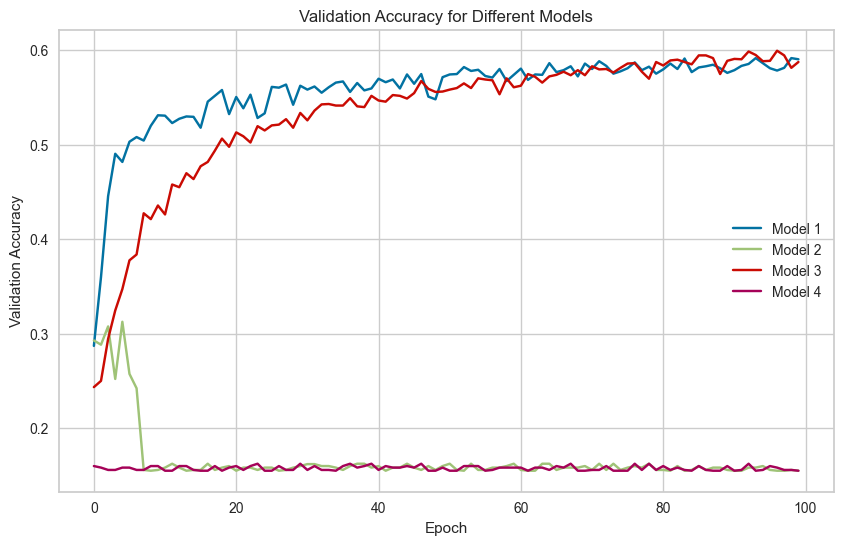

In [97]:
from keras.optimizers import Adam

# Define different sets of hyperparameters for models 2 and 3
hyperparameters = [
    {'learning_rate': 0.001, 'dropout_rate': 0.2},
    {'learning_rate': 0.01, 'dropout_rate': 0.3},
    {'learning_rate': 0.0001, 'dropout_rate': 0.2},
    {'learning_rate': 0.005, 'dropout_rate': 0.3}
]

# Initialize lists to store validation accuracy for each run
val_accuracy_history = []

# Iterate over different sets of hyperparameters
for i, params in enumerate(hyperparameters):
    print(f"Training model {i + 1}/{len(hyperparameters)} with hyperparameters: {params}")

    # Initialize the model
    model = Sequential()

    # Add convolutional layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(params['dropout_rate']))

    # Flatten the output
    model.add(Flatten())

    # Add dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with custom learning rate
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_cnn, y_train, epochs=100, validation_data=(X_test_cnn, y_test), verbose=0)

    # Append validation accuracy history to the list
    val_accuracy_history.append(history.history['val_accuracy'])

    # Print training and validation accuracy
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    print(f"Train accuracy: {train_acc}, Validation accuracy: {val_acc}")

# Plot validation accuracy for each run
plt.figure(figsize=(10, 6))
for i, val_acc in enumerate(val_accuracy_history):
    plt.plot(val_acc, label=f"Model {i+1}")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Models')
plt.legend()
plt.grid(True)
plt.show()


In [98]:
# Define hyperparameters for the new combined model
combined_hyperparameters = {
    'filters': 64,              # Filters from Model 3
    'kernel_size': 5,           # Kernel size from Model 3
    'learning_rate': 0.001,    # Learning rate from Model 3
    'dropout_rate': 0.2,        # Dropout rate from Model 3
    'optimizer': 'adam',        # Optimizer from Model 1
    'batch_size': 64            # Batch size from Model 1
}

# Initialize the model
model_combined = Sequential()

# Add convolutional layers
model_combined.add(Conv1D(filters=combined_hyperparameters['filters'], 
                          kernel_size=combined_hyperparameters['kernel_size'], 
                          activation='relu', 
                          input_shape=input_shape))
model_combined.add(MaxPooling1D(pool_size=2))
model_combined.add(Conv1D(filters=combined_hyperparameters['filters'], 
                          kernel_size=combined_hyperparameters['kernel_size'], 
                          activation='relu'))
model_combined.add(MaxPooling1D(pool_size=2))
model_combined.add(Dropout(combined_hyperparameters['dropout_rate']))

# Flatten the output
model_combined.add(Flatten())

# Add dense layers
model_combined.add(Dense(64, activation='relu'))
model_combined.add(Dense(num_classes, activation='softmax'))

# Compile the model with custom learning rate and optimizer
if combined_hyperparameters['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=combined_hyperparameters['learning_rate'])
else:
    optimizer = SGD(learning_rate=combined_hyperparameters['learning_rate'])

model_combined.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the combined model
model_combined.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 35, 64)            384       
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 17, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_21 (Conv1D)          (None, 13, 64)            20544     
                                                                 
 max_pooling1d_21 (MaxPooli  (None, 6, 64)             0         
 ng1D)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 6, 64)             0         
                                                                 
 flatten_10 (Flatten)        (None, 384)             

In [99]:
X_train_cnn.shape, X_test_cnn.shape


((9724, 39, 1), (2431, 39, 1))

In [108]:
history = model.fit(X_train_cnn, y_train, epochs=200, batch_size=64, validation_split=0.2)

# 3. Evaluate the model
test_loss, test_accuracy = model_combined.evaluate(X_test_cnn, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/200
122/122 [==============================] - 3s 21ms/step - loss: 0.9816 - accuracy: 0.6173 - val_loss: 1.0723 - val_accuracy: 0.5810
Epoch 2/200
122/122 [==============================] - 2s 18ms/step - loss: 0.9472 - accuracy: 0.6278 - val_loss: 1.0716 - val_accuracy: 0.5846
Epoch 3/200
122/122 [==============================] - 2s 18ms/step - loss: 0.9409 - accuracy: 0.6341 - val_loss: 1.0795 - val_accuracy: 0.5918
Epoch 4/200
122/122 [==============================] - 2s 18ms/step - loss: 0.9365 - accuracy: 0.6383 - val_loss: 1.0605 - val_accuracy: 0.5902
Epoch 5/200
122/122 [==============================] - 2s 19ms/step - loss: 0.9391 - accuracy: 0.6341 - val_loss: 1.0595 - val_accuracy: 0.6005
Epoch 6/200
122/122 [==============================] - 2s 19ms/step - loss: 0.9442 - accuracy: 0.6356 - val_loss: 1.0654 - val_accuracy: 0.5846
Epoch 7/200
122/122 [==============================] - 2s 19ms/step - loss: 0.9382 - accuracy: 0.6317 - val_loss: 1.1201 - val_accuracy:

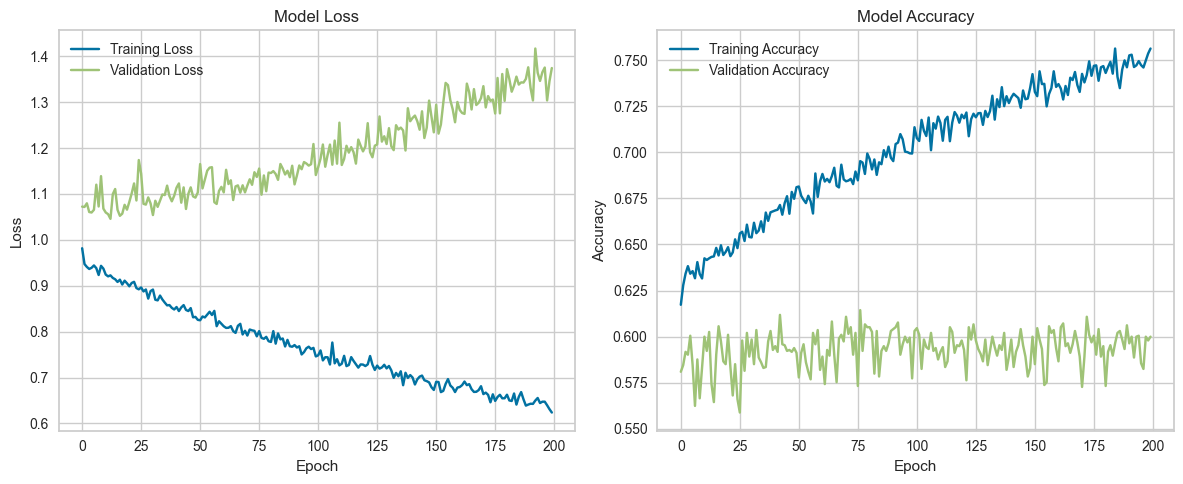

In [109]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


76/76 [==============================] - 1s 4ms/step


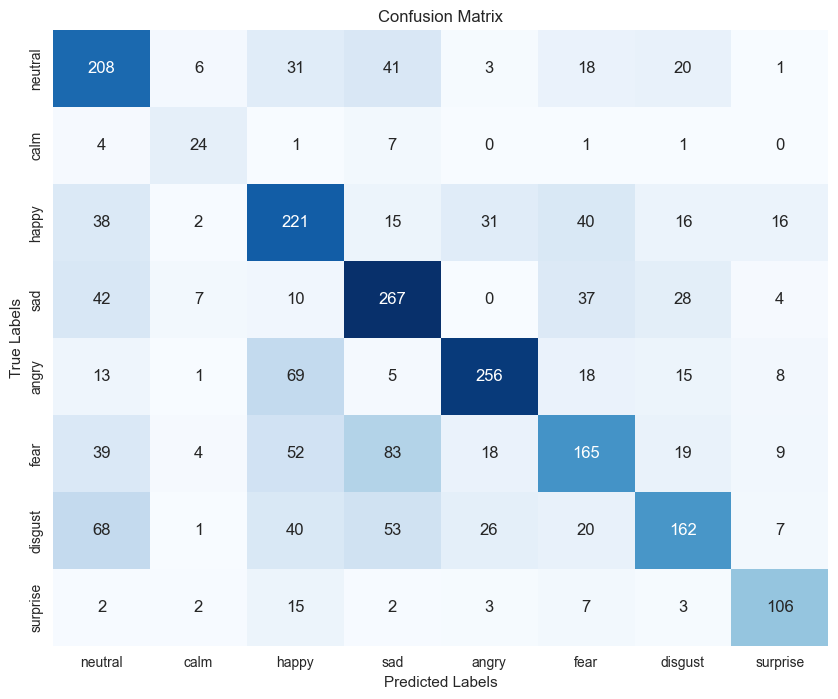

In [111]:
# Make predictions
y_pred_prob = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_prob, axis=1)

clases = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Entire Data Model Fitting 

In [103]:
final_model = ExtraTreesClassifier()

X_final = X
y_final = y.apply(lambda x: x-1)

minScaler.fit(X)

X_final = minScaler.transform(X_final)
X_final = pd.DataFrame(X_final, columns=X.columns)

final_model.fit(X_final, y_final)



ExtraTreesClassifier()

In [104]:
y_final.value_counts()

emotion_num
2              1922
3              1922
5              1922
6              1922
4              1921
0              1702
7               652
1               192
dtype: int64

# Real Predictions

In [ ]:
def run_pred(path):
    msg = extract_features(path)
    msg_t = minScaler.transform(msg)
    msg_t = pd.DataFrame(msg_t, columns=X.columns)
    y_pred_ = final_model.predict(msg_t)
    
    emotion_mapping = {
    0: 'Neutral',
    1: 'Calm',
    2: 'Happy',
    3: 'Sad',
    4: 'Angry',
    5: 'Fear',
    6: 'Disgust',
    7: 'Surprise'
     }
    
    result = emotion_mapping.get(y_pred_[0], 'Unknown')
    

    print(result)
    return Audio(path)
    

In [ ]:
path = 'matthew_happy.ogg'
run_pred(path)


In [ ]:
model.save('your_model_file.h5')

In [123]:
import tensorflow.keras.models


model = tf.keras.saving.load_model('your_model_file.h5')


# Function to preprocess audio and make predictions
def run_pred(path):
    # Extract features from audio
    data, sr = librosa.load(path)
    features = extract_features(data)  
    
    # Normalize features using the same scaler used during training
    # msg_t = minScaler.transform(features)
    
    # Reshape the features to match the input shape of the CNN model
    msg_t = features.reshape(1, features.shape[0], features.shape[1], 1)
    
    # Make predictions using the CNN model
    y_pred_prob = model.predict(msg_t)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Map the predicted labels to emotions
    emotion_mapping = {
        0: 'Neutral',
        1: 'Calm',
        2: 'Happy',
        3: 'Sad',
        4: 'Angry',
        5: 'Fear',
        6: 'Disgust',
        7: 'Surprise'
    }
    
    result = emotion_mapping.get(y_pred[0], 'Unknown')
    print(result)
    
    # Return the result
    return result

# Example usage
path = 'matthew_angry.ogg'
run_pred(path)


OSError: [Errno 22] Invalid argument: '[ 2.1537330e-06 -3.0066044e-06  9.3615233e-07 ...  2.3129240e-03\n  1.1945658e-03  4.9106288e-04]'